In [137]:
import torch
from torch.utils.data import Dataset, DataLoader

In [138]:
def filter(s):
    out = []
    s = s.strip()
    for i,char in enumerate(s): 
        if i > 0 and char != ' ':
            if (not s[i-1].isalpha()) and char.isalpha(): 
                out.append(' ' +  char)
            elif char in set('.,?!') : out.append(' ' + char)
            else: out.append(char)
        elif char != ' ': out.append(char)
    return ''.join(out)  

def read_data_fra(num_examples=None):

    with open('data/fra.txt') as f:
        # 替换字符
        source_txt = f.read().replace('\u202f', ' ').replace('\xa0', ' ').lower()
        lines = source_txt.split('\n') # 切分单个数据
        
        # 每个词元前后添加空格
        lines = [filter(line) for line in lines]
        source, target = [], []
        
        for i, line in enumerate(lines):
            
            # 自定义数量
            if num_examples and i > num_examples:
                break
            
            part = line.split('\t')
            if len(part) == 2:
                source.append(part[0].strip().split(' '))
                target.append(part[1].strip().split(' '))
                
        return source, target
                
        
source, target = read_data_fra()
print( source[:5])
print( target[:5])


[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?']]
[['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?']]


In [139]:
def filter(s):
    out = []
    s = s.strip()
    for i,char in enumerate(s): 
        if i > 0 and char != ' ':
            if (not s[i-1].isalpha()) and char.isalpha(): 
                out.append(' ' +  char)
            elif char in set('.,?!') : out.append(' ' + char)
            else: out.append(char)
        elif char != ' ': out.append(char)
    return ''.join(out)  
    return out

filter(' go away.!   \t e ')

'go away . !\t e'

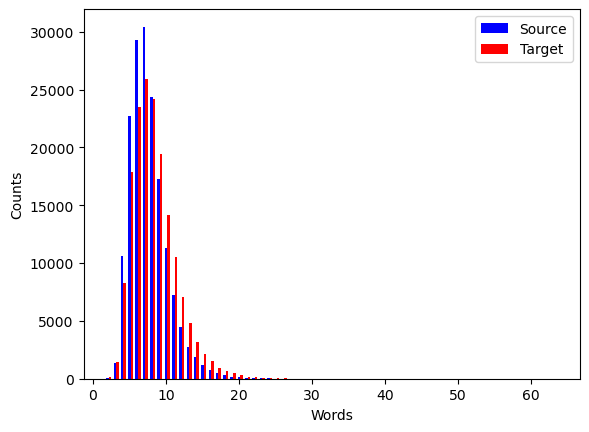

In [140]:
import matplotlib.pyplot as plt
from collections import Counter

source_counts = Counter([len(sentence) for sentence in source])
target_counts = Counter([len(sentence) for sentence in target])

# 计算每个柱子的宽度
width = 0.35

# 绘制直方图
plt.bar(source_counts.keys(), source_counts.values(), width=width, color='blue', label='Source')
plt.bar([x + width for x in target_counts.keys()], target_counts.values(), width=width, color='red', label='Target')

# 添加图例和标签
plt.legend()
plt.xlabel('Words')
plt.ylabel('Counts')

# 显示图形
plt.show()


In [141]:
import collections

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将2D词元列表展平成一个1D列表
        tokens = [token for line in tokens for token in line]
    # 使用collections.Counter统计词元的频率
    return collections.Counter(tokens)

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # 如果没有提供词元列表，则使用空列表
        if tokens is None:
            tokens = []
        # 如果没有提供保留词元列表，则使用空列表
        if reserved_tokens is None:
            reserved_tokens = []
        # 统计词元的频率并按频率降序排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 初始化词表，未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 创建从词元到索引的映射字典
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        # 遍历按频率排序后的词元和对应频率
        for token, freq in self._token_freqs:
            # 如果词元的频率小于最小频率，则停止添加
            if freq < min_freq:
                break
            # 如果词元不在词表中，则将其添加到词表并更新映射字典
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        # 返回词表的长度
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # 如果输入的是单个词元，返回其对应的索引
        if not isinstance(tokens, (list, tuple)): #不是列表或元组
            return self.token_to_idx.get(tokens, self.unk) # 字典中不存则自动返回unk
        # 如果输入的是一个词元列表，递归获取每个词元的索引
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        # 如果输入的是单个索引，返回其对应的词元
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        # 如果输入的是一个索引列表，递归获取每个索引对应的词元
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        # 返回未知词元的索引
        return 0

    @property
    def token_freqs(self):
        # 返回词元及其对应频率的列表
        return self._token_freqs
    
# 将出现次数少于2的词元过滤为unk
# 引入填充词元<pad> 开始词元 结束词元
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)


9983

In [142]:
def truncate_pad(src, padding_token, num_steps):
    # 超过长度则截断
    if (len(src) > num_steps): return src[:num_steps]
    
    # 长度不足 则补充<pad>
    return src + [padding_token] * (num_steps - len(src))

truncate_pad(src_vocab[source[0]], src_vocab['<pad>'], 10)


[51, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [147]:
def build_array(tokens, vocab, num_steps):
    # 将词元列表转换为索引列表
    tokens = [vocab[token] for token in tokens]
    # 每个序列最后添加一个eos
    tokens = [token + [vocab['<eos>']] for token in tokens]
    
    # 将处理后的定长序列构造为张量
    array = torch.tensor([
        truncate_pad(token, vocab['<pad>'], num_steps)
        for token in tokens
    ], dtype=torch.float32)
    
    # 统计非pad的词元数量
    valid_len = (array != vocab['<pad>'] ).type(torch.int32).sum(1)
    return array, valid_len

In [152]:
class fraDataset(Dataset):
    def __init__(self, src_array, src_valid_len, tgt_array, tgt_valid_len):
        self.src_array = src_array
        self.src_valid_len = src_valid_len
        self.tgt_array = tgt_array
        self.tgt_valid_len = tgt_valid_len

    def __len__(self):
        return len(self.src_array)

    def __getitem__(self, idx):
        X = self.src_array[idx]
        X_valid_len = self.src_valid_len[idx]
        Y = self.tgt_array[idx]
        Y_valid_len = self.tgt_valid_len[idx]
        
        return X, X_valid_len, Y, Y_valid_len

In [155]:
def load_data(batch_size, num_steps, num_examples=600):
    source, target = read_data_fra()
    
    # 构造词表
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    
    # 构造训练数据
    src_array, src_valid_len = build_array(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, num_steps)

    print( src_array.shape , tgt_array.shape )
    print( src_valid_len.shape , tgt_valid_len.shape )
    # 构造数据迭代器
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = fraDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=True), src_vocab, tgt_vocab

train_iter, src_vocab, tgt_vocab = load_data(batch_size=2, num_steps=8)



torch.Size([167130, 8]) torch.Size([167130, 8])
torch.Size([167130]) torch.Size([167130])


In [171]:
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break  # 只打印第一个批次的内容


X: tensor([[  66,   12,   77, 2545,    4,    3,    1,    1],
        [ 454,   74,   57,  491,   23,  109,    7,  265]], dtype=torch.int32)
X的有效长度: tensor([6, 8])
Y: tensor([[  12,   22,   43,   20,  321, 4770,    4,    3],
        [3050,    9,    6,   44, 2765,   92,   80,   13]], dtype=torch.int32)
Y的有效长度: tensor([8, 8])
